Install Dependencies

In [ ]:
%pip install torch torchvision medmnist scikit-learn matplotlib cdt networkx causal-learn torchmetrics pytorch_msssim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 823.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.9 MB/s eta 0:00:00

Imports

In [ ]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from medmnist import INFO, PathMNIST, OrganAMNIST
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
import networkx as nx
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import io
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import random
from sklearn.decomposition import PCA

Load Data (PathMNIST)

In [ ]:
# For reproducibility
torch.manual_seed(42)

# Download metadata
info_path = INFO['pathmnist']
#info_organ = INFO['organamnist']

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load PathMNIST
train_dataset_path = PathMNIST(split='train', transform=transform, download=True, size=64)
val_dataset_path = PathMNIST(split='val', transform=transform, download=True, size=64)
test_dataset_path = PathMNIST(split='test', transform=transform, download=True, size=64)

# Load OrganAMNIST
#train_dataset_organ = OrganAMNIST(split='train', transform=transform, download=True, size=64)
#val_dataset_organ = OrganAMNIST(split='val', transform=transform, download=True, size=64)
#test_dataset_organ = OrganAMNIST(split='test', transform=transform, download=True, size=64)

# Dataloaders
batch_size = 128

train_loader_path = DataLoader(train_dataset_path, batch_size=batch_size, shuffle=True)
val_loader_path = DataLoader(val_dataset_path, batch_size=batch_size, shuffle=False)
test_loader_path = DataLoader(test_dataset_path, batch_size=64, shuffle=False)

#train_loader_organ = DataLoader(train_dataset_organ, batch_size=batch_size, shuffle=True)
#val_loader_organ = DataLoader(val_dataset_organ, batch_size=batch_size, shuffle=False)


RuntimeError: 
                Automatic download failed! Please download pathmnist_64.npz manually.
                1. [Optional] Check your network connection: 
                    Go to https://github.com/MedMNIST/MedMNIST/ and find the Zenodo repository
                2. Download the npz file from the Zenodo repository or its Zenodo data link: 
                    https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1
                3. [Optional] Verify the MD5: 
                    55aa9c1e0525abe5a6b9d8343a507616
                4. Put the npz file under your MedMNIST root folder: 
                    /root/.medmnist
                

Function for Showing Samples of the Dataset

In [ ]:
def show_samples(dataset, title, n=6):
    def denormalize(img_tensor, mean=0.5, std=0.5):
        return img_tensor * std + mean

    fig, axes = plt.subplots(1, n, figsize=(12, 2))
    for i in range(n):
        img, label = dataset[i]

        if isinstance(label, (np.ndarray, torch.Tensor)):
            label = int(label.item())

        img = denormalize(img)  # Undo normalization
        img_np = img.numpy()

        if img_np.shape[0] == 1:
            img_np = img_np.squeeze(0)
            axes[i].imshow(img_np, cmap='gray')
        else:
            img_np = img_np.transpose(1, 2, 0)
            axes[i].imshow(img_np)

        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

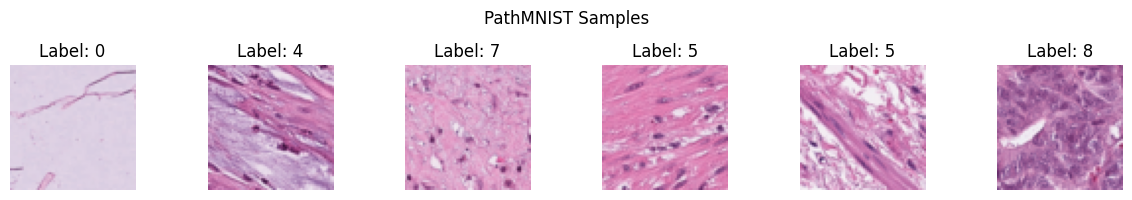

89996
10004
7180


In [ ]:
show_samples(train_dataset_path, "PathMNIST Samples")
#show_samples(train_dataset_organ, "OrganAMNIST Samples")
print(len(train_dataset_path))
print(len(val_dataset_path))
print(len(test_dataset_path))
#print(len(train_dataset_organ))
#print(len(val_dataset_organ))
#print(len(test_dataset_organ))


VAE Definition

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32, input_channels=3, dropout_prob=0.3):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob),
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob),
        )

        # Latent space
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 256 * 4 * 4)

        # Decoder (no skip connections)
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, input_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        flat = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(flat)
        logvar = self.fc_logvar(flat)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_dec(z).view(-1, 256, 4, 4)
        x = self.dec4(x)
        x = self.dec3(x)
        x = self.dec2(x)
        x = self.dec1(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

Loss

In [ ]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

Train Function

In [ ]:
def train_vae(
    model,
    train_loader,
    val_loader,
    epochs=20,
    lr=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    patience=5,
    save_path='best_vae_model.pth',
    kl_warmup_epochs=10,
    max_grad_norm=1.0
):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_loss = float('inf')
    early_stop_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]")

        # Linear warm-up of beta from 0 to 1 over kl_warmup_epochs
        beta = min(1.0, epoch / kl_warmup_epochs)

        for x, _ in pbar:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar = model(x)

            recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            loss = recon_loss + beta * kl_loss

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

            optimizer.step()

            total_train_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), beta=beta)

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_hat, mu, logvar = model(x)
                recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
                loss = recon_loss + beta * kl_loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.2f}, Val Loss = {avg_val_loss:.2f}, Beta = {beta:.3f}")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model at epoch {epoch} with val loss {avg_val_loss:.2f}")
        else:
            early_stop_counter += 1
            print(f"⚠️ No improvement. Early stop counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    return train_losses, val_losses


Training

In [ ]:
# PathMNIST VAE
vae_path = VAE(latent_dim=32)

train_losses_path, val_losses_path = train_vae(
    vae_path,
    train_loader_path,
    val_loader_path,
    epochs=20,
    lr=1e-3,
    patience=5,
    save_path='vae_pathmnist.pth'
)

Epoch 1/20 [Train]: 100%|██████████| 704/704 [00:42<00:00, 16.58it/s, beta=0.1, loss=582]


Epoch 1: Train Loss = 1585.27, Val Loss = 537.86, Beta = 0.100
✅ Saved best model at epoch 1 with val loss 537.86


Epoch 2/20 [Train]: 100%|██████████| 704/704 [00:40<00:00, 17.53it/s, beta=0.2, loss=374]


Epoch 2: Train Loss = 550.90, Val Loss = 523.11, Beta = 0.200
✅ Saved best model at epoch 2 with val loss 523.11


Epoch 3/20 [Train]: 100%|██████████| 704/704 [00:38<00:00, 18.15it/s, beta=0.3, loss=587]


Epoch 3: Train Loss = 548.01, Val Loss = 528.21, Beta = 0.300
⚠️ No improvement. Early stop counter: 1/5


Epoch 4/20 [Train]: 100%|██████████| 704/704 [00:40<00:00, 17.54it/s, beta=0.4, loss=564]


Epoch 4: Train Loss = 547.89, Val Loss = 541.14, Beta = 0.400
⚠️ No improvement. Early stop counter: 2/5


Epoch 5/20 [Train]: 100%|██████████| 704/704 [00:39<00:00, 17.62it/s, beta=0.5, loss=469]


Epoch 5: Train Loss = 550.13, Val Loss = 531.00, Beta = 0.500
⚠️ No improvement. Early stop counter: 3/5


Epoch 6/20 [Train]: 100%|██████████| 704/704 [00:40<00:00, 17.45it/s, beta=0.6, loss=671]


Epoch 6: Train Loss = 547.42, Val Loss = 544.11, Beta = 0.600
⚠️ No improvement. Early stop counter: 4/5


Epoch 7/20 [Train]: 100%|██████████| 704/704 [00:39<00:00, 17.61it/s, beta=0.7, loss=687]


Epoch 7: Train Loss = 550.51, Val Loss = 540.09, Beta = 0.700
⚠️ No improvement. Early stop counter: 5/5
⏹️ Early stopping triggered.


In [ ]:
# OrganAMNIST VAE
#vae_organ = VAE(latent_dim=32, input_channels=1)
#train_losses_organ, val_losses_organ = train_vae(
#    vae_organ,
#    train_loader_organ,
#    val_loader_organ,
#    epochs=50,
#    lr=1e-3,
#    patience=5,
#    save_path='vae_organamnist.pth'
#)

Eval mode

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae_path = VAE(latent_dim=32).to(device)  # create model and move to device
vae_path.load_state_dict(torch.load('vae_pathmnist.pth', map_location=device))  # load weights
vae_path.eval()  # set eval mode for inference


VAE(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (enc4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (fc_mu): Linear(in_features=4096, out_features=32, bias=True)
  (fc_logvar): Linear

Metrics for VAE

In [ ]:
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(device)  # For Tanh output
total_mse = 0
total_ssim = 0
n_images = 0

with torch.no_grad():
    for x, _ in tqdm(val_loader_path, desc="Evaluating VAE"):
        x = x.to(device)
        x_recon, _, _ = vae_path(x)

        # Accumulate total MSE and SSIM
        batch_size = x.size(0)
        mse = F.mse_loss(x_recon, x, reduction='sum')  # sum over batch
        ssim = ssim_metric(x_recon, x) * batch_size   # average SSIM × batch size

        total_mse += mse.item()
        total_ssim += ssim.item()
        n_images += batch_size

# Final averages
avg_mse = total_mse / n_images
avg_ssim = total_ssim / n_images

print(f"\n🔎 Average MSE: {avg_mse:.6f}")
print(f"🔎 Average SSIM: {avg_ssim:.6f}")

Evaluating VAE: 100%|██████████| 79/79 [00:04<00:00, 19.60it/s]


🔎 Average MSE: 506.263416
🔎 Average SSIM: 0.276289


Show Decoded Comparison to Original

In [ ]:
# Get dataset from the DataLoader
dataset = test_loader_path.dataset

# Sample a random index
random_idx = random.randint(0, len(dataset) - 1)

# Load the random image and label
x, _ = dataset[random_idx]

# If needed, add batch dimension for model input
x = x.unsqueeze(0)  # Shape becomes (1, C, H, W)
x = x.to(device)

# Select one image
x_single = x[0:1]  # Shape: [1, C, H, W]

# Run through the VAE
with torch.no_grad():
    x_recon, mu, logvar = vae_path(x_single)

# Optional: Unnormalize from [-1, 1] → [0, 1] for display
x_vis = (x_single + 1) / 2
x_recon_vis = (x_recon + 1) / 2

# Plot original and reconstructed image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(x_vis[0].permute(1, 2, 0).cpu())
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(x_recon_vis[0].permute(1, 2, 0).cpu())
axes[1].set_title("Reconstructed")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Extract Latent

In [ ]:
def extract_latents(model, data_loader, device='cuda'):
    model.eval()
    model = model.to(device)

    all_latents = []

    with torch.no_grad():
        for batch in data_loader:
            imgs, _ = batch
            imgs = imgs.to(device)
            mu, _ = model.encode(imgs)
            z = mu
            all_latents.append(z.detach().cpu().numpy())

    return np.concatenate(all_latents, axis=0)

In [ ]:
latents_path = extract_latents(vae_path, val_loader_path,)
#latents_organ = extract_latents(vae_organ, val_loader_organ)

In [ ]:
print(latents_path)

[[  0.6132974   -2.8560667    5.34892    ...  -0.83554673   1.278198
   -0.79696506]
 [  0.80787235   0.18485373  -1.2862542  ...  -7.2061915    0.41379887
   -1.0839205 ]
 [  0.48606753  -0.6688332   -1.7376499  ... -10.17457      0.37332273
    0.72851413]
 ...
 [  0.6633558    0.67705977  -0.48442966 ...   1.9824506    0.7176554
   -0.6808871 ]
 [  1.1457983   -0.18293294  -1.128085   ...  -5.035746    -0.09604324
   -0.25438833]
 [  0.12306383  -0.08663166  -2.0421872  ...  -3.2087016    1.2629815
   -0.22214876]]


In [ ]:
# Standardize PathMNIST latents
scaler_path = StandardScaler()
X_path_scaled = scaler_path.fit_transform(latents_path)

# Standardize OrganAMNIST latents
#scaler_organ = StandardScaler()
#X_organ_scaled = scaler_organ.fit_transform(latents_organ)

In [ ]:
print(X_path_scaled)

[[ 0.5632594  -2.2956965   3.2209303  ... -0.29998928  1.3753078
  -0.79594576]
 [ 0.74571913  0.15666565 -0.89652413 ... -2.0855074   0.43912387
  -1.0546496 ]
 [ 0.4439515  -0.5317935  -1.1766376  ... -2.917463    0.39528635
   0.5793458 ]
 ...
 [ 0.61020094  0.5536071  -0.39895228 ...  0.48981854  0.76821446
  -0.691296  ]
 [ 1.0626042  -0.13993734 -0.7983723  ... -1.4771906  -0.11305857
  -0.3067872 ]
 [ 0.10355024 -0.0622748  -1.3656181  ... -0.9651199   1.3588277
  -0.2777217 ]]


GES on Scaled Latents

In [ ]:
ges_result_path = ges(X_path_scaled, maxP=3)

In [ ]:
print(ges_result_path)

{'update1': [[29, 25, ()], [19, 2, ()], [6, 2, ()], [1, 2, ()], [19, 4, ()], [25, 1, ()], [13, 19, ()], [11, 2, (6,)], [3, 16, ()], [2, 20, ()], [2, 18, ()], [25, 3, ()], [31, 22, ()], [29, 19, ()], [20, 29, ()], [25, 23, ()], [6, 4, ()], [13, 28, ()], [4, 22, ()], [6, 19, ()], [0, 20, ()], [9, 29, ()], [1, 21, ()], [15, 9, ()], [20, 3, ()], [25, 8, ()], [10, 6, ()], [11, 4, ()], [29, 4, ()], [25, 0, ()], [6, 1, ()], [20, 9, ()], [6, 9, ()], [19, 31, ()], [13, 3, ()], [6, 29, ()], [6, 13, ()], [18, 16, ()], [17, 13, ()], [16, 5, ()], [6, 5, ()], [2, 17, ()], [4, 27, ()], [11, 12, ()], [10, 22, ()], [2, 22, ()], [1, 22, ()], [1, 28, ()], [11, 9, ()], [6, 15, ()], [28, 8, ()], [11, 19, ()], [13, 12, [11]], [20, 31, ()], [21, 31, ()], [7, 3, ()], [26, 16, ()], [16, 30, ()], [3, 21, ()], [7, 2, ()], [9, 28, ()], [1, 13, ()], [2, 21, ()], [0, 9, ()], [3, 28, ()], [11, 17, ()], [3, 23, ()], [6, 18, ()], [9, 5, ()], [22, 23, ()], [7, 30, ()], [19, 8, ()], [19, 10, ()], [17, 5, ()], [17, 15, (

Show Causal Graph

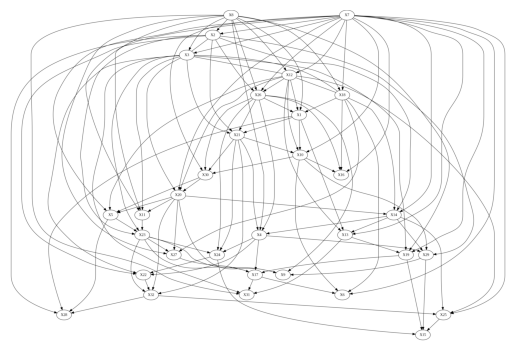

In [ ]:
pyd = GraphUtils.to_pydot(ges_result_path['G'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('path_causal_graph.png')

In [ ]:
def build_causal_features_from_parents(X, parents_dict):
    n_samples, n_latents = X.shape
    new_features = []

    for node in range(n_latents):
        parent_indices = parents_dict[node]
        combined = X[:, node:node+1]
        if parent_indices:
            combined = np.hstack([combined] + [X[:, p:p+1] for p in parent_indices])
        new_features.append(combined)

    return np.hstack(new_features)

In [ ]:
def extract_parents_from_g(graph_matrix):
    """
    graph_matrix: np.ndarray of shape (d,d) from G.graph
    Returns:
        parents_dict: dict node_idx -> list of parent indices
    """
    d = graph_matrix.shape[0]
    parents_dict = {j: [] for j in range(d)}

    for j in range(d):
        for i in range(d):
            # If edge i -> j, graph[j,i] == 1 and graph[i,j] == -1
            if graph_matrix[j, i] == 1 and graph_matrix[i, j] == -1:
                parents_dict[j].append(i)
    return parents_dict

In [ ]:
adj = ges_result_path['G'].graph  # or ges_result_path.G.graph depending on structure
parents_dict = extract_parents_from_g(adj)

# Now build causal features as before:
X_causal = build_causal_features_from_parents(X_path_scaled, parents_dict)

In [ ]:
latents_test_path = extract_latents(vae_path, test_loader_path)
scaler_test_path = StandardScaler()
test_path_scaled = scaler_test_path.fit_transform(latents_test_path)

In [ ]:
test_causal = ges(test_path_scaled, maxP=3)

In [ ]:
# Now build causal features as before:
test_causal_concat = build_causal_features_from_parents(test_path_scaled, parents_dict)

In [ ]:
y_val = np.array(val_dataset_path.labels)
y_test = np.array(test_dataset_path.labels)

Evaluation on Downstream Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_causal, y_val.ravel())

y_pred_test = clf.predict(test_causal_concat)
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_test))


Logistic Regression Test Accuracy: 0.395125348189415


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_causal, y_val.ravel())

y_pred_rf = rf_clf.predict(test_causal_concat)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Test Accuracy: 0.5693593314763231


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
mlp_clf.fit(X_causal, y_val.ravel())

y_pred_mlp = mlp_clf.predict(test_causal_concat)
print("MLP Test Accuracy:", accuracy_score(y_test, y_pred_mlp))


MLP Test Accuracy: 0.48579387186629525


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_causal, y_val.ravel())

y_pred_knn = knn_clf.predict(test_causal_concat)
print("k-NN Test Accuracy:", accuracy_score(y_test, y_pred_knn))


k-NN Test Accuracy: 0.3584958217270195


In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear')
svm_clf.fit(X_causal, y_val.ravel())

y_pred_svm = svm_clf.predict(test_causal_concat)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Test Accuracy: 0.5135097493036211


Baseline Comparisons

In [ ]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy().flatten())  # Flatten 3x64x64 into 12288 vector
        labels.append(label)
    return np.array(images), np.array(labels).ravel()

In [ ]:
X_val, y_val = dataset_to_numpy(val_dataset_path)
X_test, y_test = dataset_to_numpy(test_dataset_path)
scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
y_val = np.array(val_dataset_path.labels)
y_test = np.array(test_dataset_path.labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --------- Random Forest ---------
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_val_scaled, y_val)
y_pred_rf = rf_clf.predict(X_test_scaled)
print(f"Random Forest test accuracy (val only): {accuracy_score(y_test, y_pred_rf):.4f}")

# --------- MLP (Multi-layer Perceptron) ---------
mlp_clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)
mlp_clf.fit(X_val_scaled, y_val)
y_pred_mlp = mlp_clf.predict(X_test_scaled)
print(f"MLP test accuracy (val only): {accuracy_score(y_test, y_pred_mlp):.4f}")

# --------- K-Nearest Neighbors ---------
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_val_scaled, y_val)
y_pred_knn = knn_clf.predict(X_test_scaled)
print(f"KNN test accuracy (val only): {accuracy_score(y_test, y_pred_knn):.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest test accuracy (val only): 0.5894


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP test accuracy (val only): 0.4248


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN test accuracy (val only): 0.2432
